In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()

date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
#geosource = GeoJSONDataSource(geojson=json.dumps(d_geojson))

In [10]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [11]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [12]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
658492               2020-09-05           2020-09-02            2020-08-22   
658493               2020-09-05           2020-09-02            2020-08-22   
658494               2020-09-05           2020-09-03            2020-08-23   
658495               2020-09-05           2020-09-04            2020-08-24   
658496               2020-09-05           2020-09-04            2020-08-24   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
658492             2020-08-18 00:00:00                   NaT   
658493             2020-08-19 00:00:00                   NaT   
658494             2020-08-19 00:00:00                   NaT   
658495             2020-08-20 00:00:00                   NaT   
658496             2020-08-21 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
658492                    NaT             Medellín        Antioquia      Leve   
658493                    NaT              Pereira        Risaralda      Leve   
658494                    NaT             Medellín        Antioquia      Leve   
658495                    NaT               Soacha     Cundinamarca      Leve   
658496                    NaT               Ibagué           Tolima      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
658492            Casa  ...                10 - 20    M               NaN   
658493            Casa  ...                40 - 50    F               NaN   
658494            Casa  ...                30 - 40    F               NaN   
658495            Casa  ...                10 - 20    F               NaN   
658496            Casa  ...                20 - 30    M               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Casos activos VS Departamento (Estado)

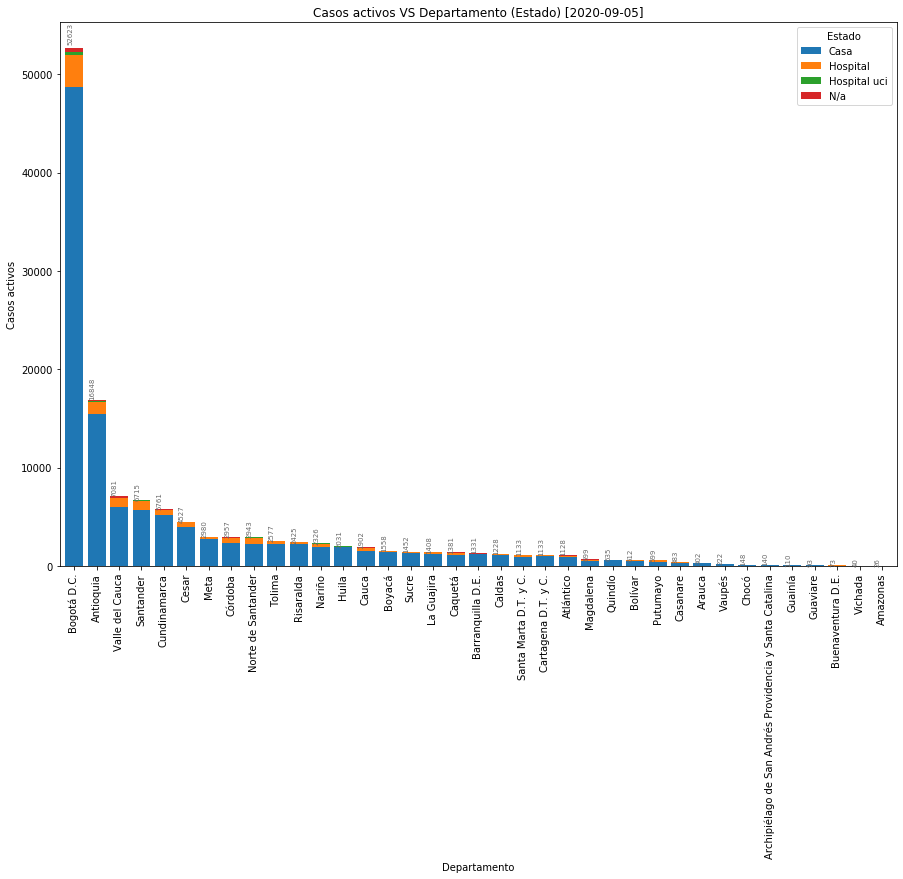

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         48735.0    3239.0   
Antioquia                                           15460.0    1181.0   
Valle del Cauca                                      5952.0     959.0   
Santander                                            5685.0     933.0   
Cundinamarca                                         5194.0     499.0   
Cesar                                                3973.0     502.0   
Meta                                                 2769.0     187.0   
Córdoba                                              2340.0     502.0   
Norte de Santander                                   2273.0     561.0   
Tolima                                               2284.0     242.0   
Risaralda                                            2199.0     200.0   
Nariño                                               1971.0     305.0   
Huila                                                1913.0      50.0   
Cauca                                                1570.0     295.0   
Boyacá                                               1403.0     133.0   
Sucre                                                1279.0     141.0   
La Guajira                                           1231.0     154.0   
Caquetá                                              1148.0     215.0   
Barranquilla D.E.                                    1179.0      45.0   
Caldas                                               1128.0      81.0   
Cartagena D.T. y C.                                  1062.0      35.0   
Santa Marta D.T. y C.                                 953.0     155.0   
Atlántico                                             948.0      81.0   
Magdalena                                             534.0     126.0   
Quindío                                               593.0      41.0   
Bolívar                                               523.0      54.0   
Putumayo                                              461.0     134.0   
Casanare                                              320.0      57.0   
Arauca                                                276.0      23.0   
Vaupés                                                212.0      10.0   
Chocó                                                  95.0      40.0   
Archipiélago de San Andrés Providencia y Santa ...    129.0      10.0   
Guainía                                               109.0       1.0   
Guaviare                                               86.0       5.0   
Buenaventura D.E.                                      47.0      20.0   
Vichada                                                38.0       1.0   
Amazonas                                               19.0       3.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                293.0  356.0   
Antioquia                                                   87.0  120.0   
Valle del Cauca                                             48.0  122.0   
Santander                                                   64.0   33.0   
Cundinamarca                                                36.0   32.0   
Cesar                                                       31.0   21.0   
Meta                                                         7.0   17.0   
Córdoba                                                     17.0   98.0   
Norte de Santander                                          88.0   21.0   
Tolima                                                      20.0   31.0   
Risaralda                                                   14.0   12.0   
Nariño                                                      17.0   33.0   
Huila                                                       52.0   16.0   
Cauca                      

### - Recuperados y Fallecidos VS Departamento

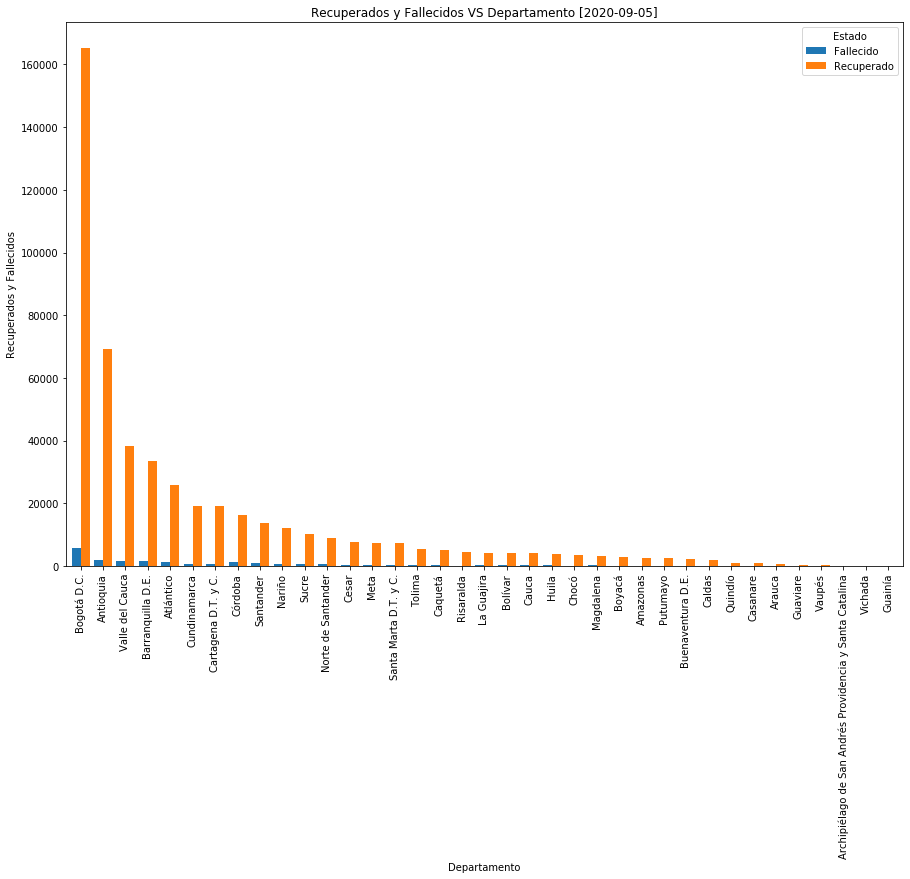

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=(f'Recuperados y Fallecidos VS Departamento [{date}]'))
ax.set_ylabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [16]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            5776.0    165123.0
Antioquia                                              1862.0     69087.0
Valle del Cauca                                        1713.0     38341.0
Barranquilla D.E.                                      1626.0     33654.0
Atlántico                                              1308.0     25918.0
Cundinamarca                                            737.0     19086.0
Cartagena D.T. y C.                                     529.0     19153.0
Córdoba                                                1389.0     16394.0
Santander                                               891.0     13667.0
Nariño                                                  557.0     12115.0
Sucre                                                   528.0     10347.0
Norte de Santander                                      712.0      8992.0
Cesar                                                   354.0      7807.0
Meta                                                    258.0      7498.0
Santa Marta D.T. y C.                                   374.0      7352.0
Tolima                                                  208.0      5468.0
Caquetá                                                 219.0      5025.0
Risaralda                                               131.0      4579.0
La Guajira                                              248.0      4181.0
Bolívar                                                 197.0      4207.0
Cauca                                                   181.0      4058.0
Huila                                                   180.0      3917.0
Chocó                                                   142.0      3492.0
Magdalena                                               349.0      3131.0
Boyacá                                                   87.0      2801.0
Amazonas                                                111.0      2575.0
Putumayo                                                141.0      2412.0
Buenaventura D.E.                                       161.0      2190.0
Caldas                                                   71.0      2031.0
Quindío                                                  48.0       885.0
Casanare                                                 28.0       819.0
Arauca                                                   21.0       767.0
Guaviare                                                  4.0       242.0
Vaupés                                                    1.0       192.0
Archipiélago de San Andrés Providencia y Santa ...        5.0       136.0
Vichada                                                   3.0        79.0
Guainía                                                   6.0        49.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

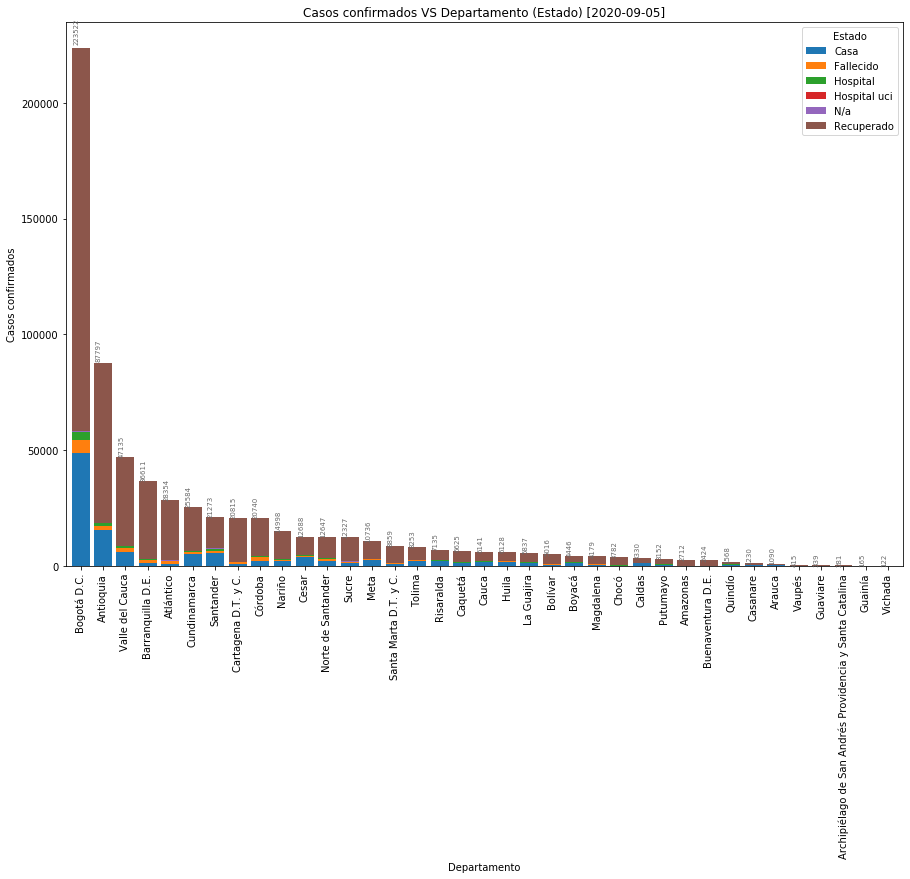

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         48735.0     5776.0   
Antioquia                                           15460.0     1862.0   
Valle del Cauca                                      5952.0     1713.0   
Barranquilla D.E.                                    1179.0     1626.0   
Atlántico                                             948.0     1308.0   
Cundinamarca                                         5194.0      737.0   
Santander                                            5685.0      891.0   
Cartagena D.T. y C.                                  1062.0      529.0   
Córdoba                                              2340.0     1389.0   
Nariño                                               1971.0      557.0   
Cesar                                                3973.0      354.0   
Norte de Santander                                   2273.0      712.0   
Sucre                                                1279.0      528.0   
Meta                                                 2769.0      258.0   
Santa Marta D.T. y C.                                 953.0      374.0   
Tolima                                               2284.0      208.0   
Risaralda                                            2199.0      131.0   
Caquetá                                              1148.0      219.0   
Cauca                                                1570.0      181.0   
Huila                                                1913.0      180.0   
La Guajira                                           1231.0      248.0   
Bolívar                                               523.0      197.0   
Boyacá                                               1403.0       87.0   
Magdalena                                             534.0      349.0   
Chocó                                                  95.0      142.0   
Caldas                                               1128.0       71.0   
Putumayo                                              461.0      141.0   
Amazonas                                               19.0      111.0   
Buenaventura D.E.                                      47.0      161.0   
Quindío                                               593.0       48.0   
Casanare                                              320.0       28.0   
Arauca                                                276.0       21.0   
Vaupés                                                212.0        1.0   
Guaviare                                               86.0        4.0   
Archipiélago de San Andrés Providencia y Santa ...    129.0        5.0   
Guainía                                               109.0        6.0   
Vichada                                                38.0        3.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           3239.0         293.0   
Antioquia                                             1181.0          87.0   
Valle del Cauca                                        959.0          48.0   
Barranquilla D.E.                                       45.0           3.0   
Atlántico                                               81.0           7.0   
Cundinamarca                                           499.0          36.0   
Santander                                              933.0          64.0   
Cartagena D.T. y C.                                     35.0           1.0   
Córdoba                                                502.0          17.0   
Nariño                                                 305.0          17.0   
Cesar                                                  502.0          31.0   
Norte de Santander                                     561.0          88.0   
Sucre                

### - Casos confirmados VS Departamento (Sexo)

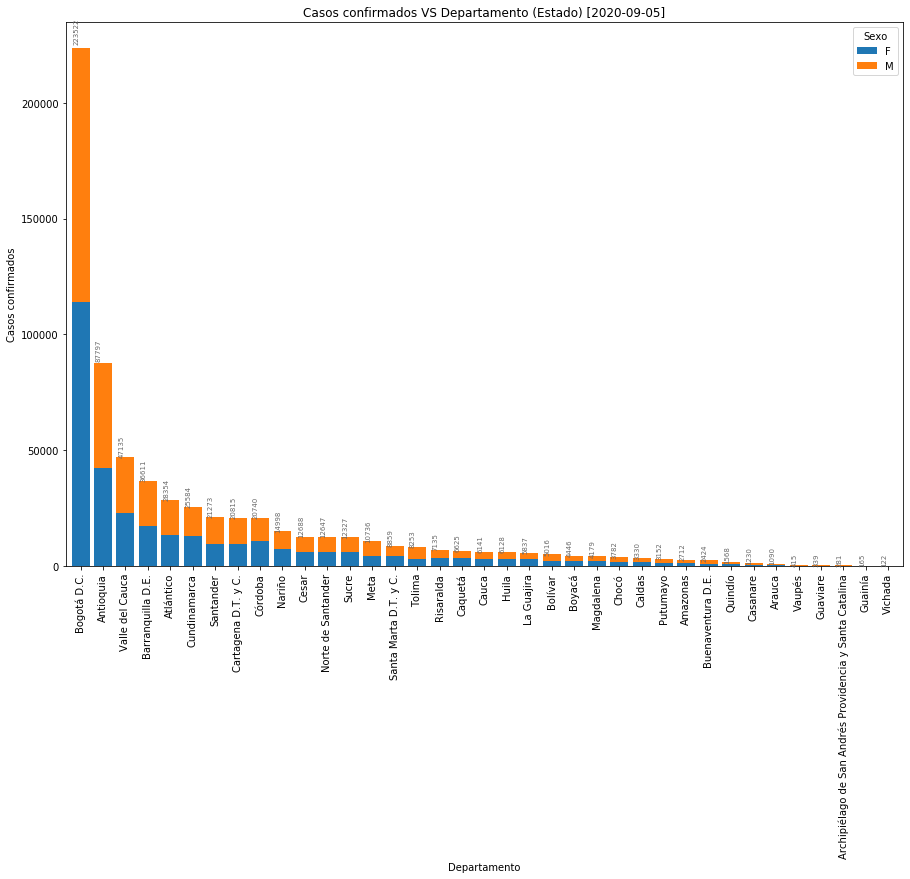

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         113893  109629  223522
Antioquia                                            42305   45492   87797
Valle del Cauca                                      22946   24189   47135
Barranquilla D.E.                                    17305   19306   36611
Atlántico                                            13425   14929   28354
Cundinamarca                                         12998   12586   25584
Santander                                             9439   11834   21273
Cartagena D.T. y C.                                   9631   11184   20815
Córdoba                                              10674   10066   20740
Nariño                                                7247    7751   14998
Cesar                                                 6058    6630   12688
Norte de Santander                                    5857    6790   12647
Sucre                                                 6035    6292   12327
Meta                                                  4201    6535   10736
Santa Marta D.T. y C.                                 4441    4418    8859
Tolima                                                3247    5006    8253
Risaralda                                             3418    3717    7135
Caquetá                                               3296    3329    6625
Cauca                                                 2972    3169    6141
Huila                                                 3050    3078    6128
La Guajira                                            2974    2863    5837
Bolívar                                               2350    2666    5016
Boyacá                                                2083    2363    4446
Magdalena                                             2120    2059    4179
Chocó                                                 1796    1986    3782
Caldas                                                1584    1746    3330
Putumayo                                              1460    1692    3152
Amazonas                                              1168    1544    2712
Buenaventura D.E.                                      906    1518    2424
Quindío                                                781     787    1568
Casanare                                               525     705    1230
Arauca                                                 388     702    1090
Vaupés                                                 183     232     415
Guaviare                                                80     259     339
Archipiélago de San Andrés Providencia y Santa ...     153     128     281
Guainía                                                 67      98     165
Vichada                                                 33      89     122

### - Mapa de influencia COVID-19 (Colombia)

In [21]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

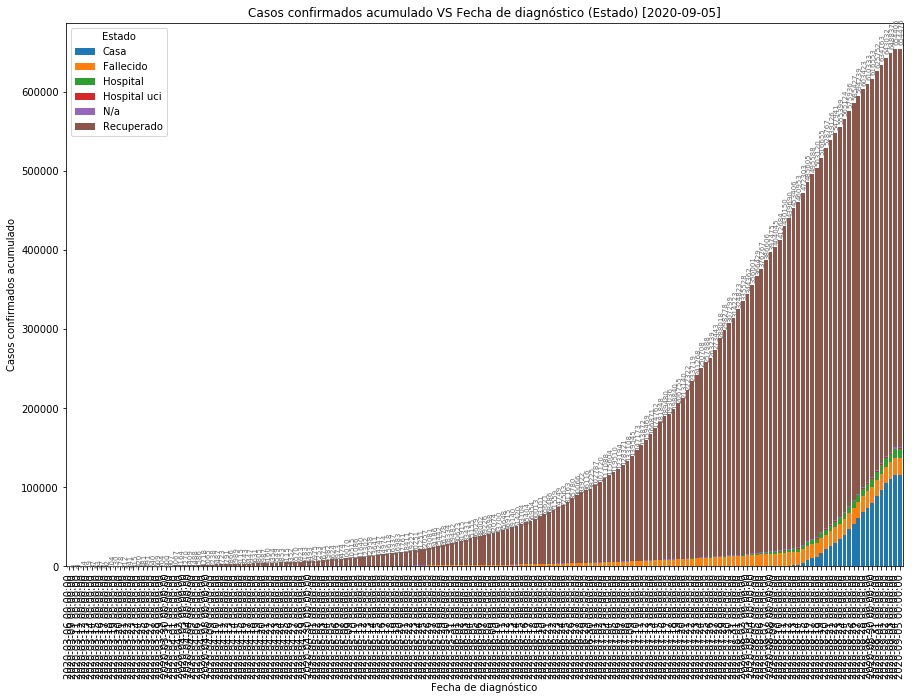

In [22]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [23]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-09-05            115959.0    20950.0   11216.0         862.0  1332.0   
2020-09-04            115890.0    20950.0   11214.0         862.0  1332.0   
2020-09-03            110450.0    20950.0   11119.0         833.0  1332.0   
2020-09-02            104943.0    20910.0   10866.0         828.0  1332.0   
2020-09-01             96459.0    20790.0   10642.0         804.0  1325.0   
2020-08-31             88525.0    20706.0   10379.0         801.0  1323.0   
2020-08-30             79995.0    20605.0    9991.0         798.0  1317.0   
2020-08-29             74269.0    20533.0    9714.0         788.0  1311.0   
2020-08-28             68378.0    20428.0    9431.0         761.0  1306.0   
2020-08-27             60440.0    20292.0    8950.0         726.0  1304.0   
2020-08-26             53366.0    20139.0    8534.0         690.0  1294.0   
2020-08-25             46872.0    19924.0    8122.0         639.0  1284.0   
2020-08-24             39594.0    19737.0    7741.0         608.0  1272.0   
2020-08-23             34171.0    19507.0    7362.0         569.0  1257.0   
2020-08-22             29982.0    19373.0    7074.0         547.0  1254.0   
2020-08-21             25435.0    19150.0    6673.0         533.0  1246.0   
2020-08-20             21254.0    18903.0    6241.0         498.0  1227.0   
2020-08-19             17295.0    18519.0    5674.0         443.0  1212.0   
2020-08-18             11559.0    18215.0    5201.0         390.0  1195.0   
2020-08-17             10329.0    17968.0    4910.0         382.0  1174.0   
2020-08-16              8190.0    17782.0    4646.0         359.0  1165.0   
2020-08-15              3902.0    17482.0    4279.0         332.0  1156.0   
2020-08-14              1392.0    17183.0    3910.0         313.0  1147.0   
2020-08-13              1140.0    16941.0    3674.0         302.0  1137.0   
2020-08-12               946.0    16625.0    3286.0         277.0  1120.0   
2020-08-11               718.0    16260.0    2940.0         251.0  1107.0   
2020-08-10               521.0    15844.0    2416.0         210.0  1086.0   
2020-08-09               418.0    15613.0    2141.0         189.0  1068.0   
2020-08-08               261.0    15387.0    1910.0         177.0  1061.0   
2020-08-07               230.0    15063.0    1666.0         155.0  1045.0   
2020-08-06               188.0    14768.0    1402.0         114.0  1025.0   
2020-08-05               163.0    14478.0    1172.0          80.0  1004.0   
2020-08-04               130.0    14181.0     888.0          50.0   981.0   
2020-08-03               101.0    13852.0     611.0          19.0   964.0   
2020-08-02                70.0    13506.0     355.0           9.0   943.0   
2020-08-01                67.0    13137.0     296.0           4.0   929.0   
2020-07-31                60.0    12787.0     263.0           3.0   908.0   
2020-07-30                55.0    12542.0     228.0           3.0   892.0   
2020-07-29                53.0    12246.0     207.0           3.0   871.0   
2020-07-28                45.0    11945.0     186.0           3.0   848.0   
2020-07-27                42.0    11384.0     167.0           3.0   806.0   
2020-07-26                39.0    11053.0     141.0           3.0   781.0   
2020-07-25                38.0    10806.0     134.0           3.0   767.0   
2020-07-24                34.0    10498.0     120.0           2.0   749.0   
2020-07-23                28.0    10192.0      96.0           2.0   728.0   
2020-07-22                24.0     9813.0      88.0           2.0   699.0   
2020-07-21                20.0     9364.0      76.0           2.0   672.0   
2020-07-20                19.0     9014.0      67.0           1.0   657.0   
2020-07-19                18.0     8740.0      57.0           1.0   645.0   
2020-07-18                18.0     8457.0      47.0           1.0   628.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

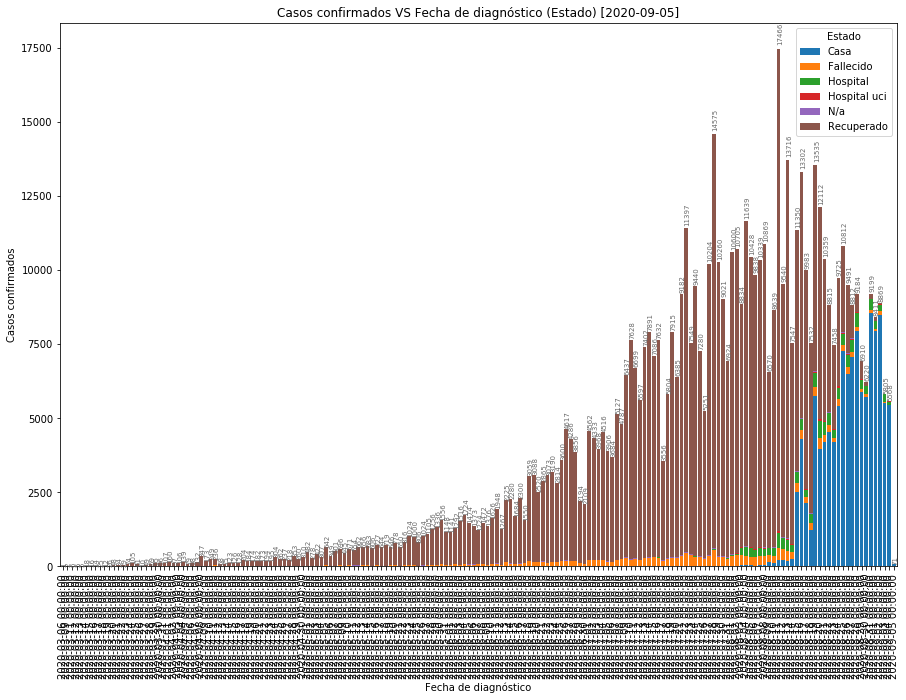

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-09-05              69.0        0.0       2.0           0.0   0.0   
2020-09-04            5440.0        0.0      95.0          29.0   0.0   
2020-09-03            5507.0       40.0     253.0           5.0   0.0   
2020-09-02            8484.0      120.0     224.0          24.0   7.0   
2020-09-01            7934.0       84.0     263.0           3.0   2.0   
2020-08-31            8530.0      101.0     388.0           3.0   6.0   
2020-08-30            5726.0       72.0     277.0          10.0   6.0   
2020-08-29            5891.0      105.0     283.0          27.0   5.0   
2020-08-28            7938.0      136.0     481.0          35.0   2.0   
2020-08-27            7074.0      153.0     416.0          36.0  10.0   
2020-08-26            6494.0      215.0     412.0          51.0  10.0   
2020-08-25            7278.0      187.0     381.0          31.0  12.0   
2020-08-24            5423.0      230.0     379.0          39.0  15.0   
2020-08-23            4189.0      134.0     288.0          22.0   3.0   
2020-08-22            4547.0      223.0     401.0          14.0   8.0   
2020-08-21            4181.0      247.0     432.0          35.0  19.0   
2020-08-20            3959.0      384.0     567.0          55.0  15.0   
2020-08-19            5736.0      304.0     473.0          53.0  17.0   
2020-08-18            1230.0      247.0     291.0           8.0  21.0   
2020-08-17            2139.0      186.0     264.0          23.0   9.0   
2020-08-16            4288.0      300.0     367.0          27.0   9.0   
2020-08-15            2510.0      299.0     369.0          19.0   9.0   
2020-08-14             252.0      242.0     236.0          11.0  10.0   
2020-08-13             194.0      316.0     388.0          25.0  17.0   
2020-08-12             228.0      365.0     346.0          26.0  13.0   
2020-08-11             197.0      416.0     524.0          41.0  21.0   
2020-08-10             103.0      231.0     275.0          21.0  18.0   
2020-08-09             157.0      226.0     231.0          12.0   7.0   
2020-08-08              31.0      324.0     244.0          22.0  16.0   
2020-08-07              42.0      295.0     264.0          41.0  20.0   
2020-08-06              25.0      290.0     230.0          34.0  21.0   
2020-08-05              33.0      297.0     284.0          30.0  23.0   
2020-08-04              29.0      329.0     277.0          31.0  17.0   
2020-08-03              31.0      346.0     256.0          10.0  21.0   
2020-08-02               3.0      369.0      59.0           5.0  14.0   
2020-08-01               7.0      350.0      33.0           1.0  21.0   
2020-07-31               5.0      245.0      35.0           0.0  16.0   
2020-07-30               2.0      296.0      21.0           0.0  21.0   
2020-07-29               8.0      301.0      21.0           0.0  23.0   
2020-07-28               3.0      561.0      19.0           0.0  42.0   
2020-07-27               3.0      331.0      26.0           0.0  25.0   
2020-07-26               1.0      247.0       7.0           0.0  14.0   
2020-07-25               4.0      308.0      14.0           1.0  18.0   
2020-07-24               6.0      306.0      24.0           0.0  21.0   
2020-07-23               4.0      379.0       8.0           0.0  29.0   
2020-07-22               4.0      449.0      12.0           0.0  27.0   
2020-07-21               1.0      350.0       9.0           1.0  15.0   
2020-07-20               1.0      274.0      10.0           0.0  12.0   
2020-07-19               0.0      283.0      10.0           0.0  17.0   
2020-07-18               2.0      245.0      12.0           0.0  22.0   
2020-07-17               0.0      177.0      10.0           1.0   9.0   
2020-07-16               3.0      289.0       6.0           0.0  20.0   
2020-07-15               0.0      299.0       4.0         

### - Casos confirmados VS Clasificación de edad (Estado)

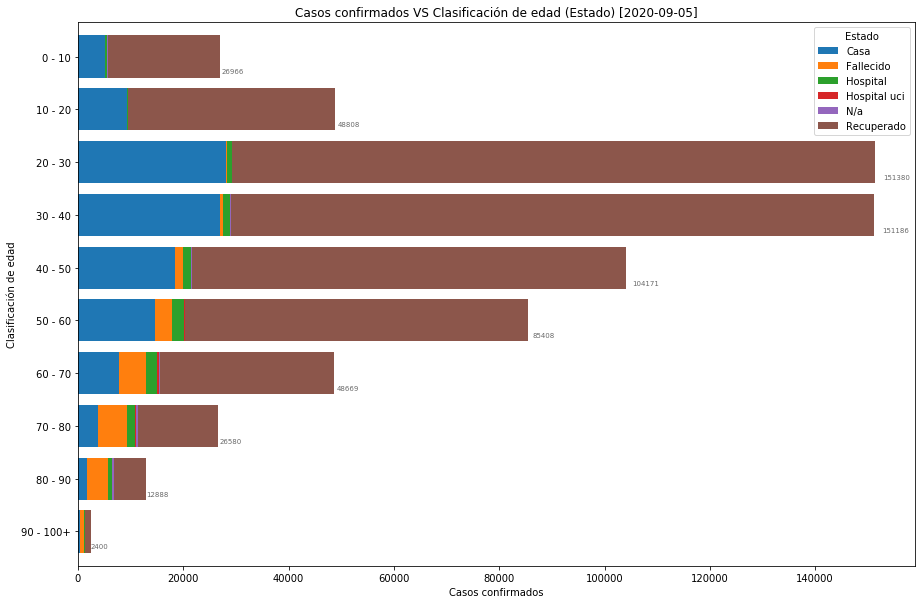

In [26]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Estado) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [27]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  5071         35       492            10   32   
10 - 20                 9276         34       234            10   25   
20 - 30                28100        269       843            30   59   
30 - 40                26934        685      1244            69   50   
40 - 50                18389       1539      1494           109  100   
50 - 60                14636       3164      2259           189  162   
60 - 70                 7828       5088      2185           220  282   
70 - 80                 3843       5421      1582           163  321   
80 - 90                 1700       4016       777            61  262   
90 - 100+                314        905       110             2   63   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      21326  
10 - 20                     39229  
20 - 30                    122079  
30 - 40                    122204  
40 - 50                     82540  
50 - 60                     64998  
60 - 70                     33066  
70 - 80                     15250  
80 - 90                      6072  
90 - 100+                    1006

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

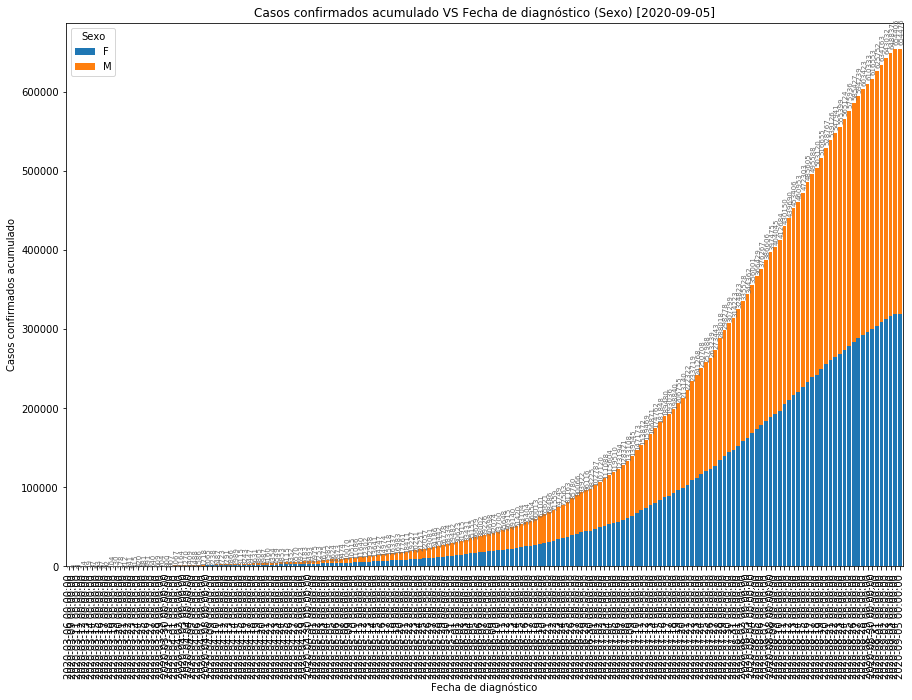

In [28]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [29]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-09-05            319194.0  335282.0
2020-09-04            319155.0  335250.0
2020-09-03            316132.0  332705.0
2020-09-02            313172.0  329860.0
2020-09-01            308628.0  325535.0
2020-08-31            304408.0  321344.0
2020-08-30            299558.0  316995.0
2020-08-29            296401.0  313932.0
2020-08-28            292899.0  310524.0
2020-08-27            288270.0  305969.0
2020-08-26            283839.0  301588.0
2020-08-25            278998.0  296938.0
2020-08-24            273568.0  291556.0
2020-08-23            268704.0  286695.0
2020-08-22            264927.0  283014.0
2020-08-21            260770.0  278356.0
2020-08-20            255548.0  273219.0
2020-08-19            249445.0  267210.0
2020-08-18            242400.0  260720.0
2020-08-17            238764.0  256824.0
2020-08-16            233491.0  252114.0
2020-08-15            226538.0  245765.0
2020-08-14            220772.0  240181.0
2020-08-13            216906.0  236500.0
2020-08-12            210042.0  229648.0
2020-08-11            205314.0  224836.0
2020-08-10            196262.0  216422.0
2020-08-09            191925.0  212120.0
2020-08-08            188539.0  208936.0
2020-08-07            183248.0  203358.0
2020-08-06            178196.0  198071.0
2020-08-05            173322.0  193107.0
2020-08-04            168103.0  187898.0
2020-08-03            162266.0  182096.0
2020-08-02            157995.0  177533.0
2020-08-01            152522.0  172301.0
2020-07-31            147392.0  166831.0
2020-07-30            143923.0  163376.0
2020-07-29            139533.0  158745.0
2020-07-28            134446.0  153572.0
2020-07-27            127352.0  146091.0
2020-07-26            122475.0  140764.0
2020-07-25            120068.0  137920.0
2020-07-24            116394.0  134314.0
2020-07-23            112032.0  129236.0
2020-07-22            108469.0  125250.0
2020-07-21            103324.0  118998.0
2020-07-20             99031.0  114109.0
2020-07-19             96050.0  110705.0
2020-07-18             92263.0  106577.0
2020-07-17             89489.0  103547.0
2020-07-16             87735.0  101745.0
2020-07-15             84000.0   97848.0
2020-07-14             80647.0   94115.0
2020-07-13             77056.0   89815.0
2020-07-12             73517.0   85952.0
2020-07-11             70853.0   83019.0
2020-07-10             67672.0   79501.0
2020-07-09             64185.0   75360.0
2020-07-08             61273.0   71835.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

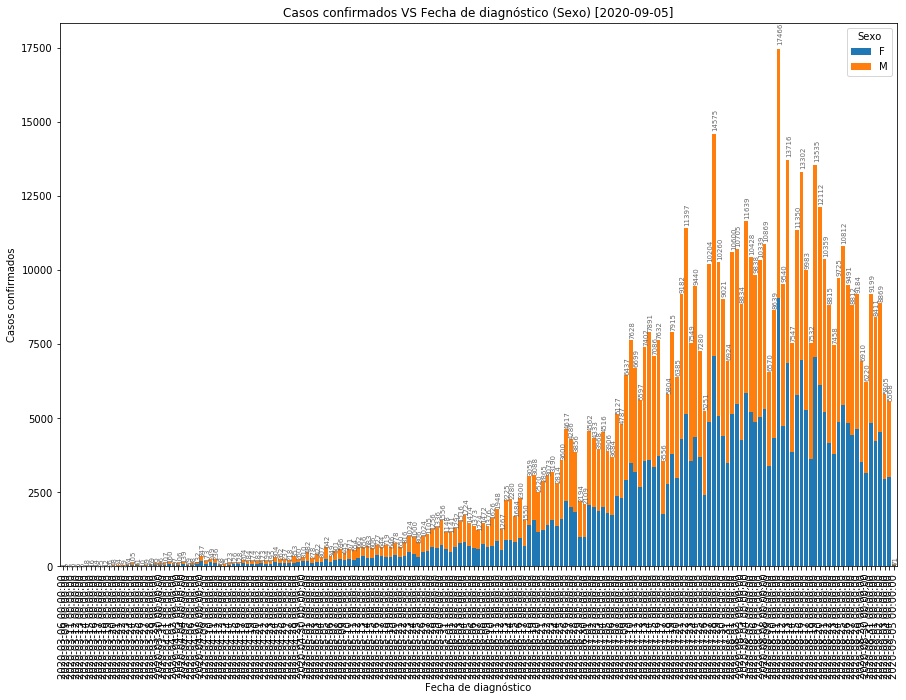

In [30]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [31]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-09-05              39.0    32.0
2020-09-04            3023.0  2545.0
2020-09-03            2960.0  2845.0
2020-09-02            4544.0  4325.0
2020-09-01            4220.0  4191.0
2020-08-31            4850.0  4349.0
2020-08-30            3157.0  3063.0
2020-08-29            3502.0  3408.0
2020-08-28            4629.0  4555.0
2020-08-27            4431.0  4381.0
2020-08-26            4841.0  4650.0
2020-08-25            5430.0  5382.0
2020-08-24            4864.0  4861.0
2020-08-23            3777.0  3681.0
2020-08-22            4157.0  4658.0
2020-08-21            5222.0  5137.0
2020-08-20            6103.0  6009.0
2020-08-19            7045.0  6490.0
2020-08-18            3636.0  3896.0
2020-08-17            5273.0  4710.0
2020-08-16            6953.0  6349.0
2020-08-15            5766.0  5584.0
2020-08-14            3866.0  3681.0
2020-08-13            6864.0  6852.0
2020-08-12            4728.0  4812.0
2020-08-11            9052.0  8414.0
2020-08-10            4337.0  4302.0
2020-08-09            3386.0  3184.0
2020-08-08            5291.0  5578.0
2020-08-07            5052.0  5287.0
2020-08-06            4874.0  4964.0
2020-08-05            5219.0  5209.0
2020-08-04            5837.0  5802.0
2020-08-03            4271.0  4563.0
2020-08-02            5473.0  5232.0
2020-08-01            5130.0  5470.0
2020-07-31            3469.0  3455.0
2020-07-30            4390.0  4631.0
2020-07-29            5087.0  5173.0
2020-07-28            7094.0  7481.0
2020-07-27            4877.0  5327.0
2020-07-26            2407.0  2844.0
2020-07-25            3674.0  3606.0
2020-07-24            4362.0  5078.0
2020-07-23            3563.0  3986.0
2020-07-22            5145.0  6252.0
2020-07-21            4293.0  4889.0
2020-07-20            2981.0  3404.0
2020-07-19            3787.0  4128.0
2020-07-18            2774.0  3030.0
2020-07-17            1754.0  1802.0
2020-07-16            3735.0  3897.0
2020-07-15            3353.0  3733.0
2020-07-14            3591.0  4300.0
2020-07-13            3539.0  3863.0
2020-07-12            2664.0  2933.0
2020-07-11            3181.0  3518.0
2020-07-10            3487.0  4141.0
2020-07-09            2912.0  3525.0
2020-07-08            2299.0  2488.0

### - Casos confirmados VS Clasificación de edad (Sexo)

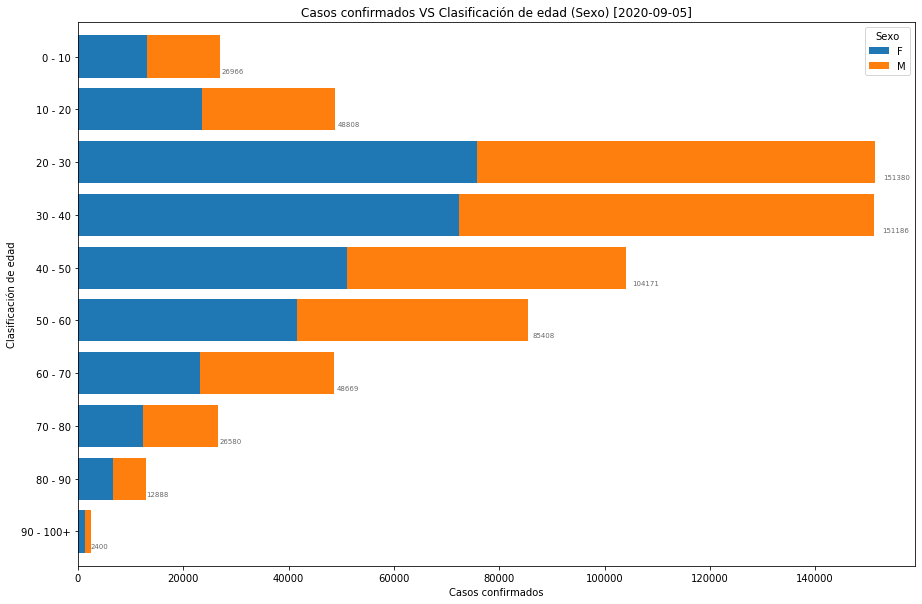

In [32]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [33]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 13152  13814
10 - 20                23585  25223
20 - 30                75732  75648
30 - 40                72340  78846
40 - 50                51141  53030
50 - 60                41516  43892
60 - 70                23253  25416
70 - 80                12413  14167
80 - 90                 6598   6290
90 - 100+               1359   1041

### - Casos confirmados VS Estado (Sexo)

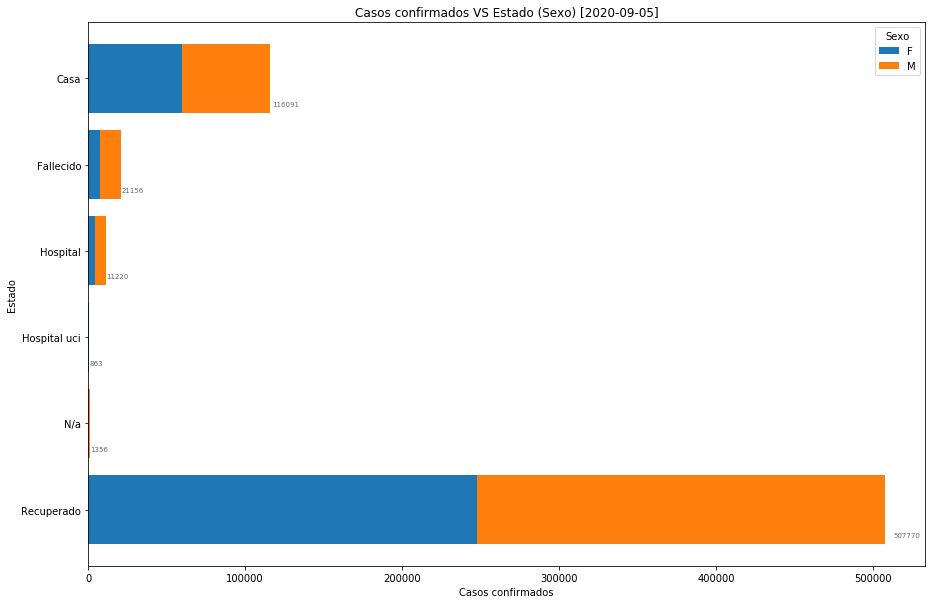

In [34]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [35]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           59859   56232
Fallecido       7593   13563
Hospital        4707    6513
Hospital uci     313     550
N/a              584     772
Recuperado    248033  259737

### - Casos confirmados VS Tipo de contagio (Sexo)

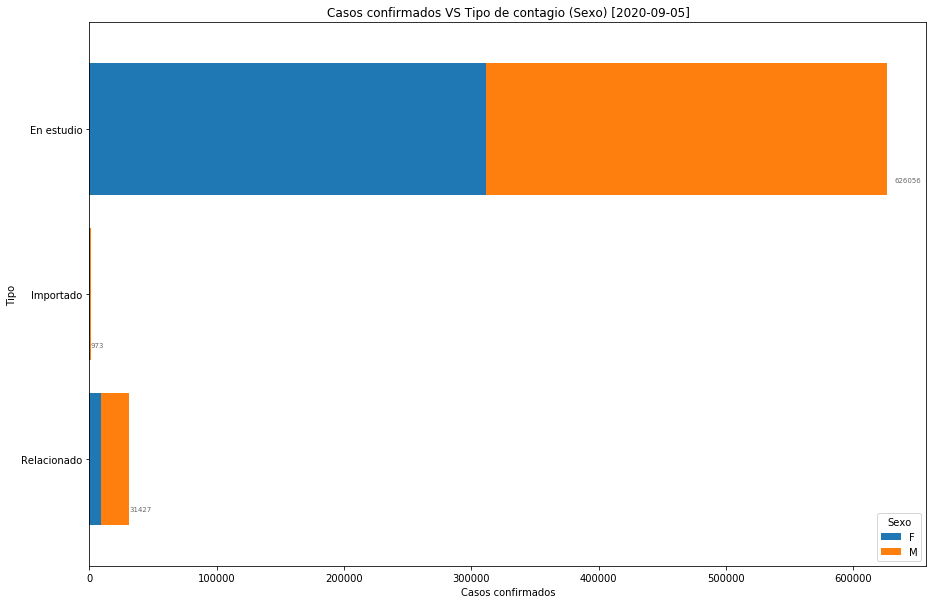

In [36]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo de contagio (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [37]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   311809  314247
Importado       460     513
Relacionado    8820   22607

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

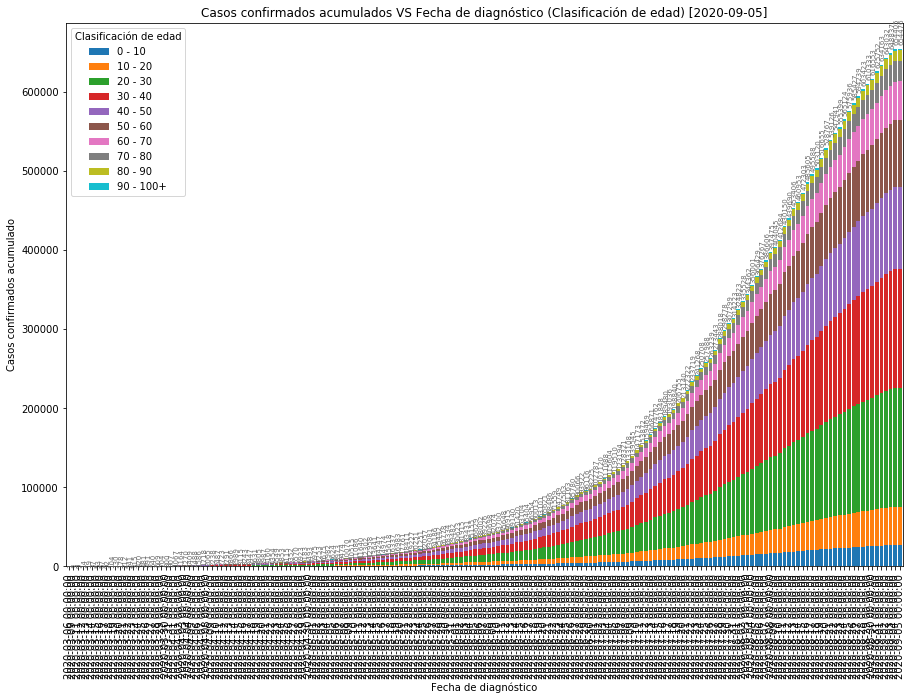

In [38]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [39]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-05              26827    48521   150413   150230   103583    84924   
2020-09-04              26821    48520   150398   150213   103575    84909   
2020-09-03              26612    48160   149113   148963   102688    84159   
2020-09-02              26398    47716   147759   147666   101773    83367   
2020-09-01              26034    47100   145773   145709   100399    82188   
2020-08-31              25695    46445   143845   143808    99097    81071   
2020-08-30              25280    45741   141640   141762    97643    79941   
2020-08-29              25035    45272   140168   140362    96666    79145   
2020-08-28              24784    44747   138554   138843    95595    78196   
2020-08-27              24461    44123   136497   136685    94155    76963   
2020-08-26              24115    43486   134443   134666    92749    75835   
2020-08-25              23764    42773   132399   132508    91211    74650   
2020-08-24              23373    42076   129947   129961    89461    73206   
2020-08-23              23009    41361   127684   127779    87938    71945   
2020-08-22              22699    40756   125907   126042    86835    70962   
2020-08-21              22377    40096   123874   123944    85509    69848   
2020-08-20              21954    39347   121410   121585    83871    68493   
2020-08-19              21468    38488   118749   118866    81945    66878   
2020-08-18              20838    37493   115705   115838    79723    65165   
2020-08-17              20583    36979   114028   114139    78522    64135   
2020-08-16              20069    36219   111815   112038    76929    62797   
2020-08-15              19451    35082   108856   109140    74813    61047   
2020-08-14              18951    34242   106243   106633    73024    59520   
2020-08-13              18698    33696   104514   104956    71807    58457   
2020-08-12              18075    32632   101408   101852    69615    56652   
2020-08-11              17727    31995    99320    99644    68099    55386   
2020-08-10              16930    30739    95197    95603    65260    53137   
2020-08-09              16599    30058    93247    93597    63906    52022   
2020-08-08              16353    29630    91734    92167    62821    51135   
2020-08-07              15933    28844    89286    89515    61110    49711   
2020-08-06              15516    28073    86926    87078    59466    48373   
2020-08-05              15066    27328    84738    84832    57886    47093   
2020-08-04              14639    26602    82346    82417    56196    45723   
2020-08-03              14149    25779    79678    79693    54283    44138   
2020-08-02              13825    25169    77675    77640    52936    42917   
2020-08-01              13382    24449    75263    75244    51127    41415   
2020-07-31              12968    23591    72705    72730    49505    40066   
2020-07-30              12691    23126    71169    71088    48327    39207   
2020-07-29              12347    22411    68984    68947    46997    38024   
2020-07-28              11965    21662    66554    66464    45304    36779   
2020-07-27              11336    20530    63237    63180    42987    34850   
2020-07-26              10949    19808    60839    60790    41312    33635   
2020-07-25              10737    19482    59648    59557    40497    32951   
2020-07-24              10453    19001    58009    57853    39332    31962   
2020-07-23              10132    18283    55804    55563    37853    30732   
2020-07-22               9856    17768    54120    53815    36651    29741   
2020-07-21               9451    16922    51406    51230    34869    28197   
2020-07-20               9092    16296    49242    49046    33385    27043   
2020-07-19               8814    15836    47882    47582    32314    26214   
2020-07-18            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

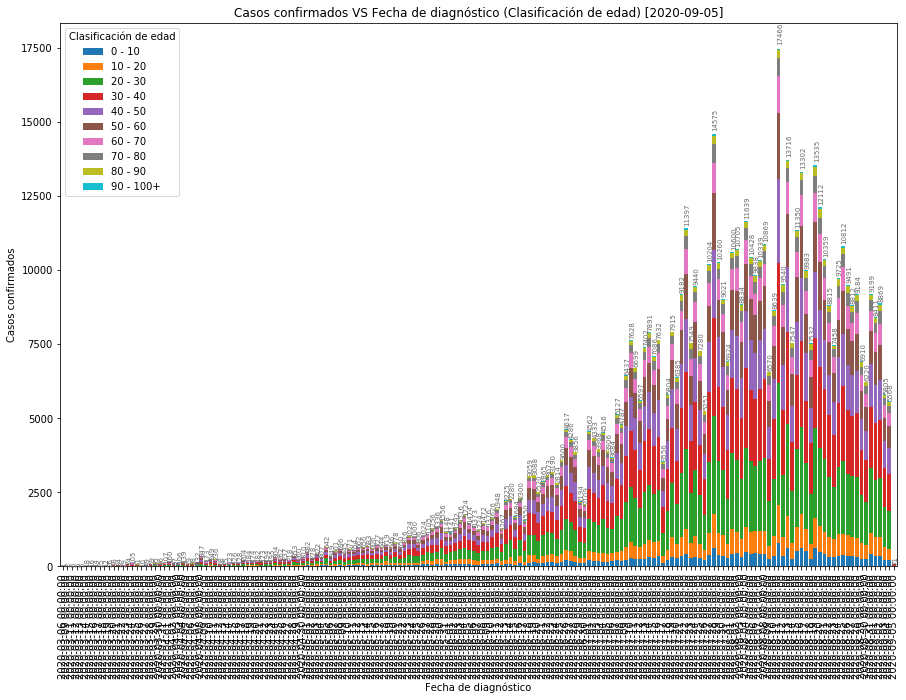

In [40]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [41]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-05                  6        1       15       17        8       15   
2020-09-04                209      360     1285     1250      887      750   
2020-09-03                214      444     1354     1297      915      792   
2020-09-02                364      616     1986     1957     1374     1179   
2020-09-01                339      655     1928     1901     1302     1117   
2020-08-31                415      704     2205     2046     1454     1130   
2020-08-30                245      469     1472     1400      977      796   
2020-08-29                251      525     1614     1519     1071      949   
2020-08-28                323      624     2057     2158     1440     1233   
2020-08-27                346      637     2054     2019     1406     1128   
2020-08-26                351      713     2044     2158     1538     1185   
2020-08-25                391      697     2452     2547     1750     1444   
2020-08-24                364      715     2263     2182     1523     1261   
2020-08-23                310      605     1777     1737     1103      983   
2020-08-22                322      660     2033     2098     1326     1114   
2020-08-21                423      749     2464     2359     1638     1355   
2020-08-20                486      859     2661     2719     1926     1615   
2020-08-19                630      995     3044     3028     2222     1713   
2020-08-18                255      514     1677     1699     1201     1030   
2020-08-17                514      760     2213     2101     1593     1338   
2020-08-16                618     1137     2959     2898     2116     1750   
2020-08-15                500      840     2613     2507     1789     1527   
2020-08-14                253      546     1729     1677     1217     1063   
2020-08-13                623     1064     3106     3104     2192     1805   
2020-08-12                348      637     2088     2208     1516     1266   
2020-08-11                797     1256     4123     4041     2839     2249   
2020-08-10                331      681     1950     2006     1354     1115   
2020-08-09                246      428     1513     1430     1085      887   
2020-08-08                420      786     2448     2652     1711     1424   
2020-08-07                417      771     2360     2437     1644     1338   
2020-08-06                450      745     2188     2246     1580     1280   
2020-08-05                427      726     2392     2415     1690     1370   
2020-08-04                490      823     2668     2724     1913     1585   
2020-08-03                324      610     2003     2053     1347     1221   
2020-08-02                443      720     2412     2396     1809     1502   
2020-08-01                414      858     2558     2514     1622     1349   
2020-07-31                277      465     1536     1642     1178      859   
2020-07-30                344      715     2185     2141     1330     1183   
2020-07-29                382      749     2430     2483     1693     1245   
2020-07-28                629     1132     3317     3284     2317     1929   
2020-07-27                387      722     2398     2390     1675     1215   
2020-07-26                212      326     1191     1233      815      684   
2020-07-25                284      481     1639     1704     1165      989   
2020-07-24                321      718     2205     2290     1479     1230   
2020-07-23                276      515     1684     1748     1202      991   
2020-07-22                405      846     2714     2585     1782     1544   
2020-07-21                359      626     2164     2184     1484     1154   
2020-07-20                278      460     1360     1464     1071      829   
2020-07-19                312      661     1837     1857     1311      981   
2020-07-18            

### - Casos confirmados VS Estado (Clasificación de edad)

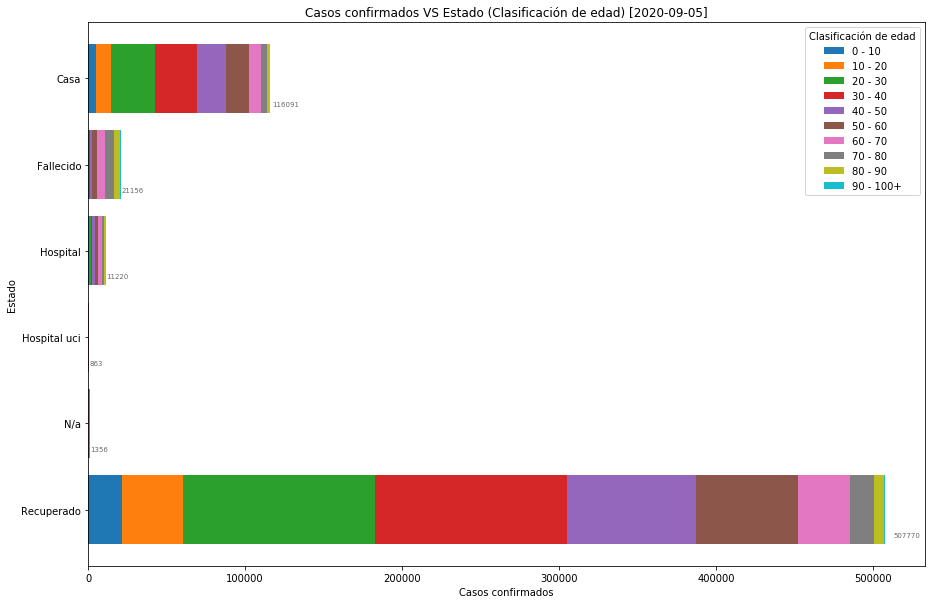

In [42]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [43]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     5071     9276    28100    26934    18389    14636   
Fallecido                  35       34      269      685     1539     3164   
Hospital                  492      234      843     1244     1494     2259   
Hospital uci               10       10       30       69      109      189   
N/a                        32       25       59       50      100      162   
Recuperado              21326    39229   122079   122204    82540    64998   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      7828     3843     1700        314  
Fallecido                 5088     5421     4016        905  
Hospital                  2185     1582      777        110  
Hospital uci               220      163       61          2  
N/a                        282      321      262         63  
Recuperado               33066    15250     6072       1006

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

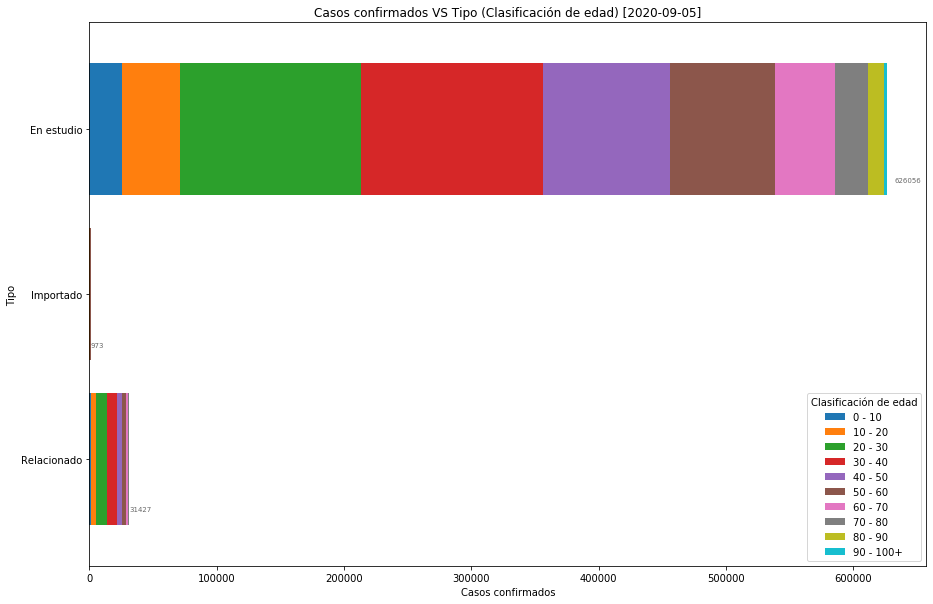

In [44]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [45]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              25940    44923   142366   142861   100006    82526   
Importado                   7       37      241      224      172      146   
Relacionado              1019     3848     8773     8101     3993     2736   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               47112    25790    12293       2239  
Importado                   98       37       10          1  
Relacionado               1459      753      585        160

## Y para los curiosos... 👀

### - Casos activos VS Ciudad de ubicación (Estado) [TOP 50]

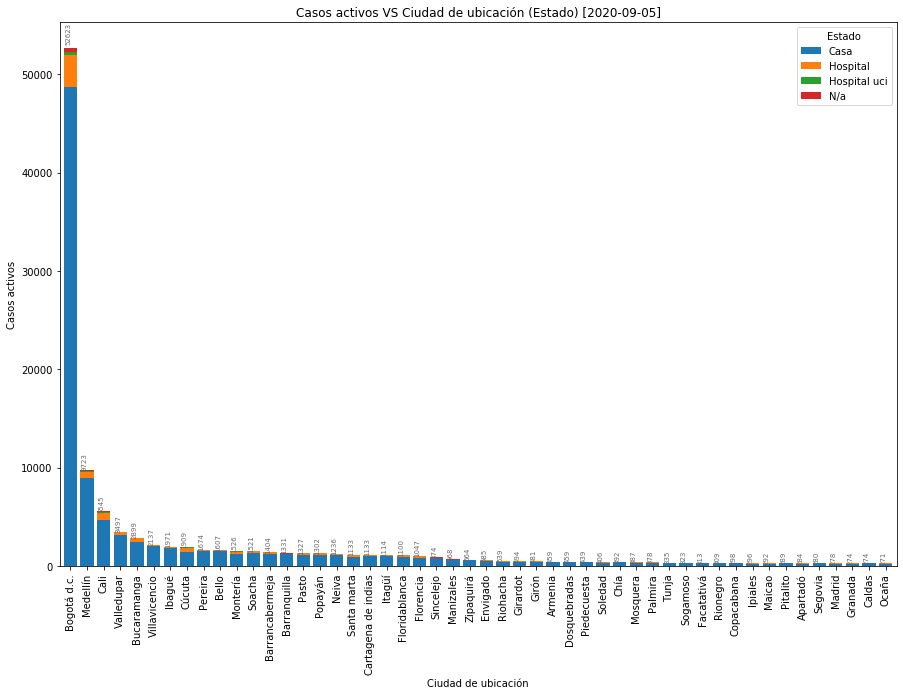

In [46]:
li = data.groupby(['Ciudad de ubicación', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').tail(50).iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Ciudad de ubicación (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [47]:
li.sort_values('Total', ascending=False).head(50)

Estado                  Casa  Hospital  Hospital uci    N/a    Total
Ciudad de ubicación                                                 
Bogotá d.c.          48735.0    3239.0         293.0  356.0  52623.0
Medellín              8981.0     629.0          51.0   62.0   9723.0
Cali                  4725.0     690.0          38.0   92.0   5545.0
Valledupar            3154.0     312.0          21.0   10.0   3497.0
Bucaramanga           2472.0     382.0          31.0   14.0   2899.0
Villavicencio         2003.0     116.0           6.0   12.0   2137.0
Ibagué                1810.0     128.0          14.0   19.0   1971.0
Cúcuta                1456.0     388.0          53.0   12.0   1909.0
Pereira               1523.0     131.0          11.0    9.0   1674.0
Bello                 1517.0      76.0           9.0    5.0   1607.0
Montería              1230.0     240.0          10.0   46.0   1526.0
Soacha                1362.0     141.0          11.0    7.0   1521.0
Barrancabermeja       1250.0     145.0           5.0    4.0   1404.0
Barranquilla          1179.0      45.0           3.0  104.0   1331.0
Pasto                 1122.0     177.0          13.0   15.0   1327.0
Popayán               1120.0     166.0           6.0   10.0   1302.0
Neiva                 1167.0      33.0          29.0    7.0   1236.0
Santa marta            953.0     155.0           7.0   18.0   1133.0
Cartagena de indias   1062.0      35.0           1.0   35.0   1133.0
Itagüí                1057.0      48.0           4.0    5.0   1114.0
Floridablanca          915.0     167.0          13.0    5.0   1100.0
Florencia              853.0     183.0           3.0    8.0   1047.0
Sincelejo              796.0      58.0           6.0   14.0    874.0
Manizales              629.0      28.0           2.0    9.0    668.0
Zipaquirá              633.0      26.0           2.0    3.0    664.0
Envigado               554.0      27.0           2.0    2.0    585.0
Riohacha               459.0      70.0           4.0    6.0    539.0
Girardot               441.0      50.0           3.0    0.0    494.0
Girón                  389.0      86.0           3.0    3.0    481.0
Dosquebradas           409.0      47.0           2.0    1.0    459.0
Armenia                427.0      31.0           0.0    1.0    459.0
Piedecuesta            372.0      62.0           5.0    0.0    439.0
Soledad                319.0      43.0           2.0   42.0    406.0
Chía                   365.0      23.0           1.0    3.0    392.0
Mosquera               348.0      32.0           5.0    2.0    387.0
Palmira                293.0      77.0           1.0    7.0    378.0
Tunja                  305.0      22.0           2.0    6.0    335.0
Sogamoso               310.0      11.0           1.0    1.0    323.0
Facatativá             289.0      21.0           3.0    0.0    313.0
Rionegro               273.0      31.0           3.0    2.0    309.0
Copacabana             289.0       7.0           0.0    2.0    298.0
Ipiales                235.0      57.0           1.0    3.0    296.0
Maicao                 250.0      34.0           7.0    1.0    292.0
Pitalito               267.0       9.0          10.0    3.0    289.0
Apartadó               235.0      43.0           1.0    5.0    284.0
Segovia                273.0       6.0           1.0    0.0    280.0
Madrid                 253.0      23.0           1.0    1.0    278.0
Caldas                 263.0      11.0           0.0    0.0    274.0
Granada                259.0      14.0           1.0    0.0    274.0
Ocaña                  196.0      69.0           5.0    1.0    271.0

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>

In [48]:
# Data storage
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)